# Microsoft Revenue Forecasting with ARIMA and Prophet

This notebook builds forecasting models for Microsoft's key financial metrics:
- Revenue
- Cost of Revenue
- Research and Development

We'll use two popular time series forecasting methods:
1. **ARIMA** (AutoRegressive Integrated Moving Average)
2. **Facebook Prophet**

In [19]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series specific imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Interactive plotting with plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

## 1. Load and Prepare Data

In [20]:
# Load the processed data
df = pd.read_csv('../data/processed/microsoft_master_long_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Filter for the metrics we want to forecast
metrics_to_forecast = ['Revenue', 'Cost of Revenue', 'Research and Development']
forecast_data = df[df['Metric'].isin(metrics_to_forecast)].copy()

# Pivot to wide format for easier analysis
forecast_wide = forecast_data.pivot(index='Date', columns='Metric', values='Value')
forecast_wide = forecast_wide.sort_index()

print(f"Data shape: {forecast_wide.shape}")
print(f"Date range: {forecast_wide.index.min()} to {forecast_wide.index.max()}")
print(f"\nFirst few rows:")
forecast_wide.head()

Data shape: (47, 3)
Date range: 2013-09-30 00:00:00 to 2025-03-31 00:00:00

First few rows:


Metric,Cost of Revenue,Research and Development,Revenue
Date,,,
2013-09-30,5114.0,2767.0,18529.0
2013-12-31,8284.0,2748.0,24519.0
2014-03-31,5941.0,2743.0,20403.0
2014-06-30,7595.0,3123.0,23382.0
2014-09-30,8273.0,3065.0,23201.0


In [21]:
# Create time series data dictionary for easier handling
time_series_data = {}

for metric in metrics_to_forecast:
    metric_data = df[df['Metric'] == metric][['Date', 'Value']].copy()
    metric_data = metric_data.sort_values('Date')
    metric_data.set_index('Date', inplace=True)
    time_series_data[metric] = metric_data
    
print("Time series data created for:", list(time_series_data.keys()))

Time series data created for: ['Revenue', 'Cost of Revenue', 'Research and Development']


In [22]:
# Check for missing values
print("Missing values:")
print(forecast_wide.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
forecast_wide.describe()

Missing values:
Metric
Cost of Revenue             0
Research and Development    0
Revenue                     0
dtype: int64

Basic statistics:


Metric,Cost of Revenue,Research and Development,Revenue
count,47.000000,47.000000,47.000000
mean,12192.127660,4785.425532,37522.957447
std,4474.864723,1740.161246,15658.602560
min,5114.000000,2743.000000,18529.000000
25%,8281.000000,3114.500000,23589.000000
50%,10975.000000,4513.000000,33055.000000
75%,15871.500000,6467.000000,50925.000000
max,21919.000000,8198.000000,70066.000000


## 2. Exploratory Data Analysis

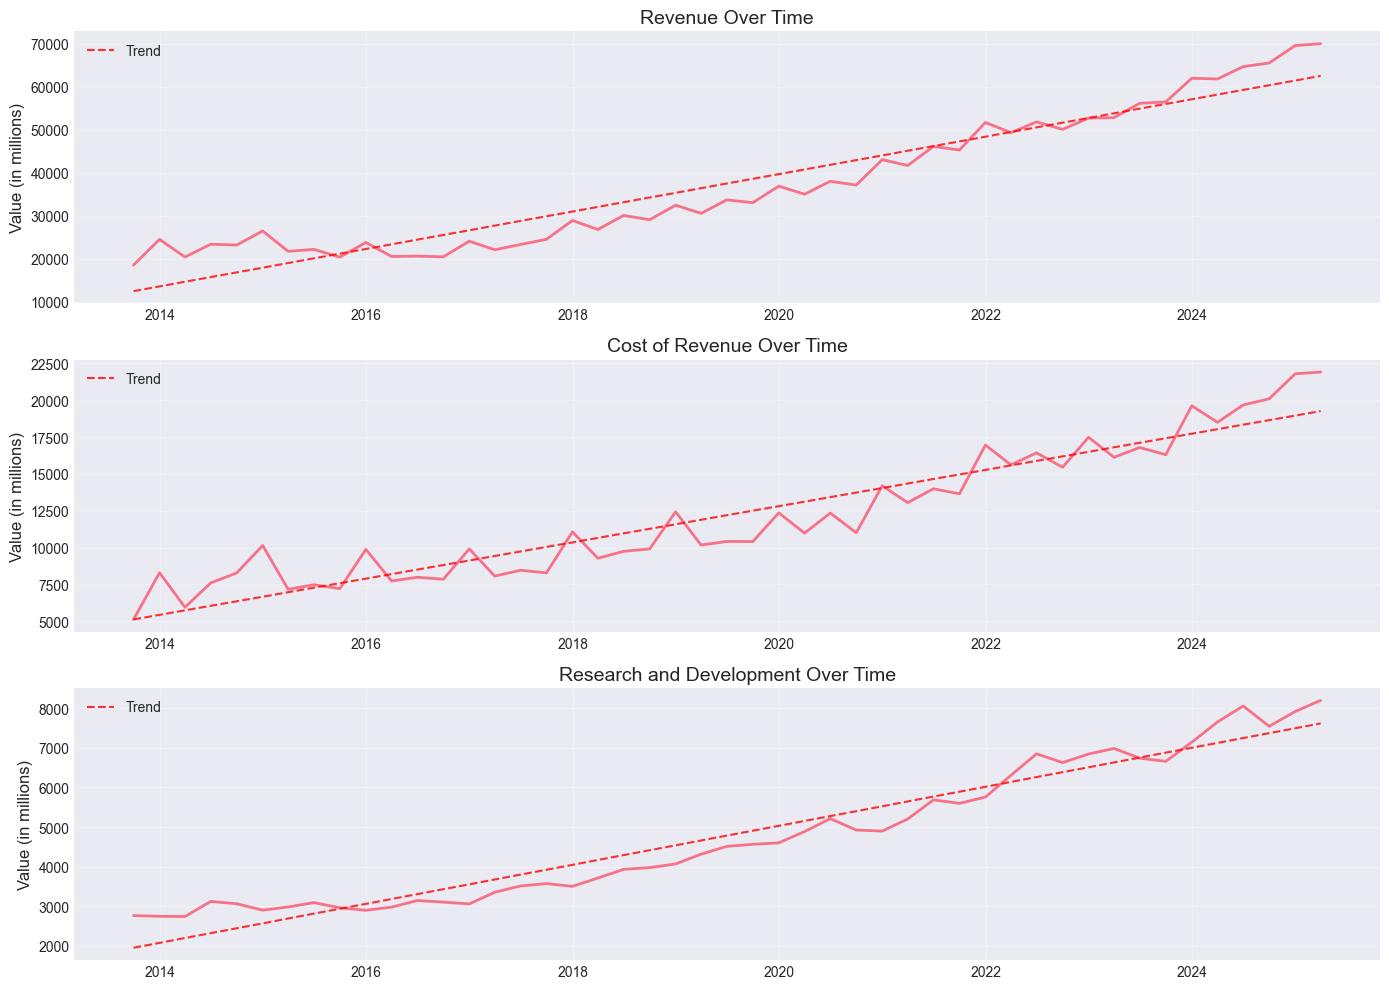

In [23]:
# Plot the time series
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx, metric in enumerate(metrics_to_forecast):
    axes[idx].plot(forecast_wide.index, forecast_wide[metric], linewidth=2)
    axes[idx].set_title(f'{metric} Over Time', fontsize=14)
    axes[idx].set_ylabel('Value (in millions)', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(range(len(forecast_wide)), forecast_wide[metric], 1)
    p = np.poly1d(z)
    axes[idx].plot(forecast_wide.index, p(range(len(forecast_wide))), "r--", alpha=0.8, label='Trend')
    axes[idx].legend()

plt.tight_layout()
plt.show()

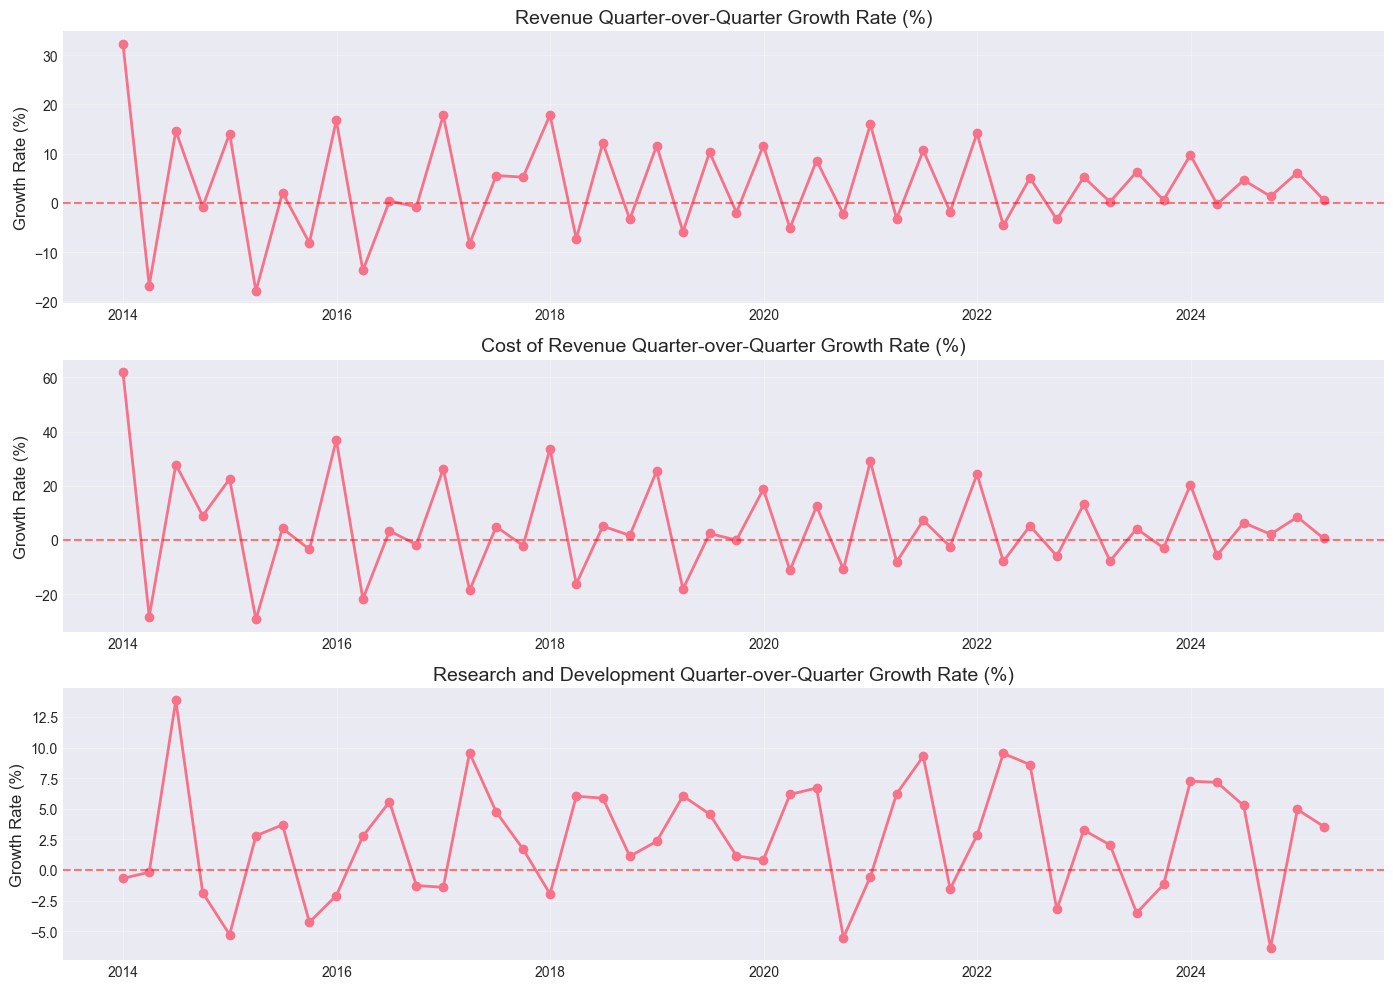

Average Quarter-over-Quarter Growth Rates:
Revenue: 3.40%
Cost of Revenue: 4.67%
Research and Development: 2.49%


In [24]:
# Calculate quarter-over-quarter growth rates
growth_rates = forecast_wide.pct_change() * 100

# Plot growth rates
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx, metric in enumerate(metrics_to_forecast):
    axes[idx].plot(growth_rates.index[1:], growth_rates[metric][1:], linewidth=2, marker='o')
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[idx].set_title(f'{metric} Quarter-over-Quarter Growth Rate (%)', fontsize=14)
    axes[idx].set_ylabel('Growth Rate (%)', fontsize=12)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print average growth rates
print("Average Quarter-over-Quarter Growth Rates:")
for metric in metrics_to_forecast:
    avg_growth = growth_rates[metric].mean()
    print(f"{metric}: {avg_growth:.2f}%")


Seasonal Decomposition for Revenue


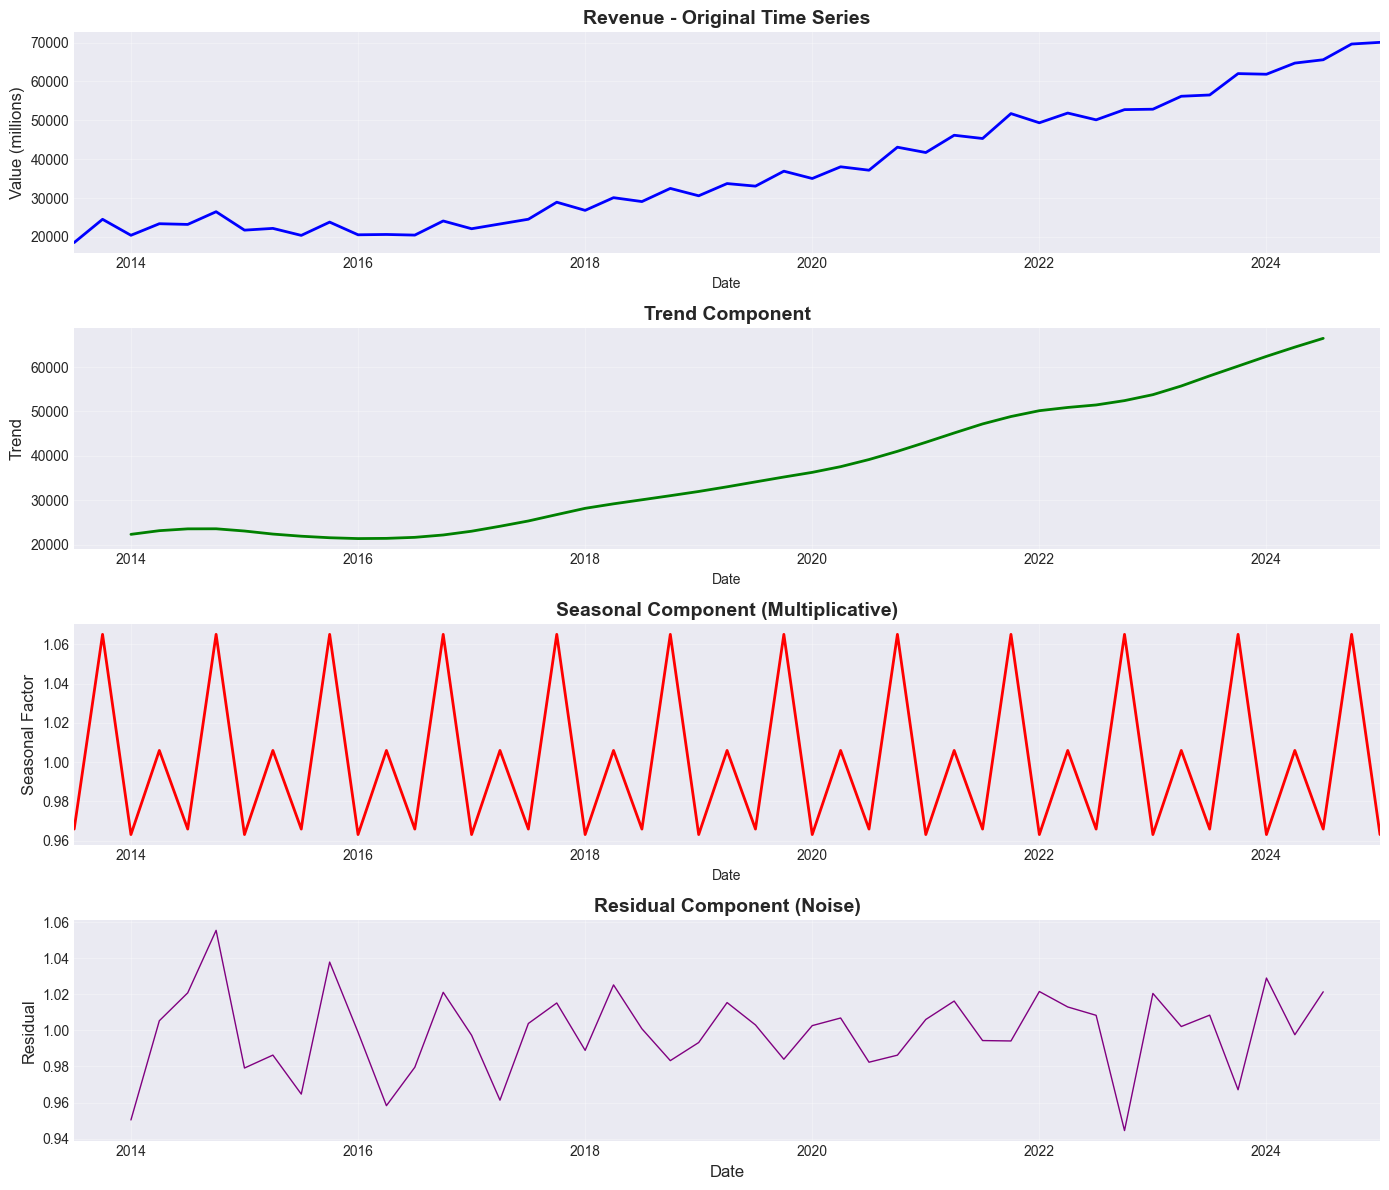


Average Seasonal Factors by Quarter:
  Q1: 0.963 (-3.7% from baseline)
  Q2: 1.006 (+0.6% from baseline)
  Q3: 0.966 (-3.4% from baseline)
  Q4: 1.065 (+6.5% from baseline)

Seasonal Decomposition for Cost of Revenue


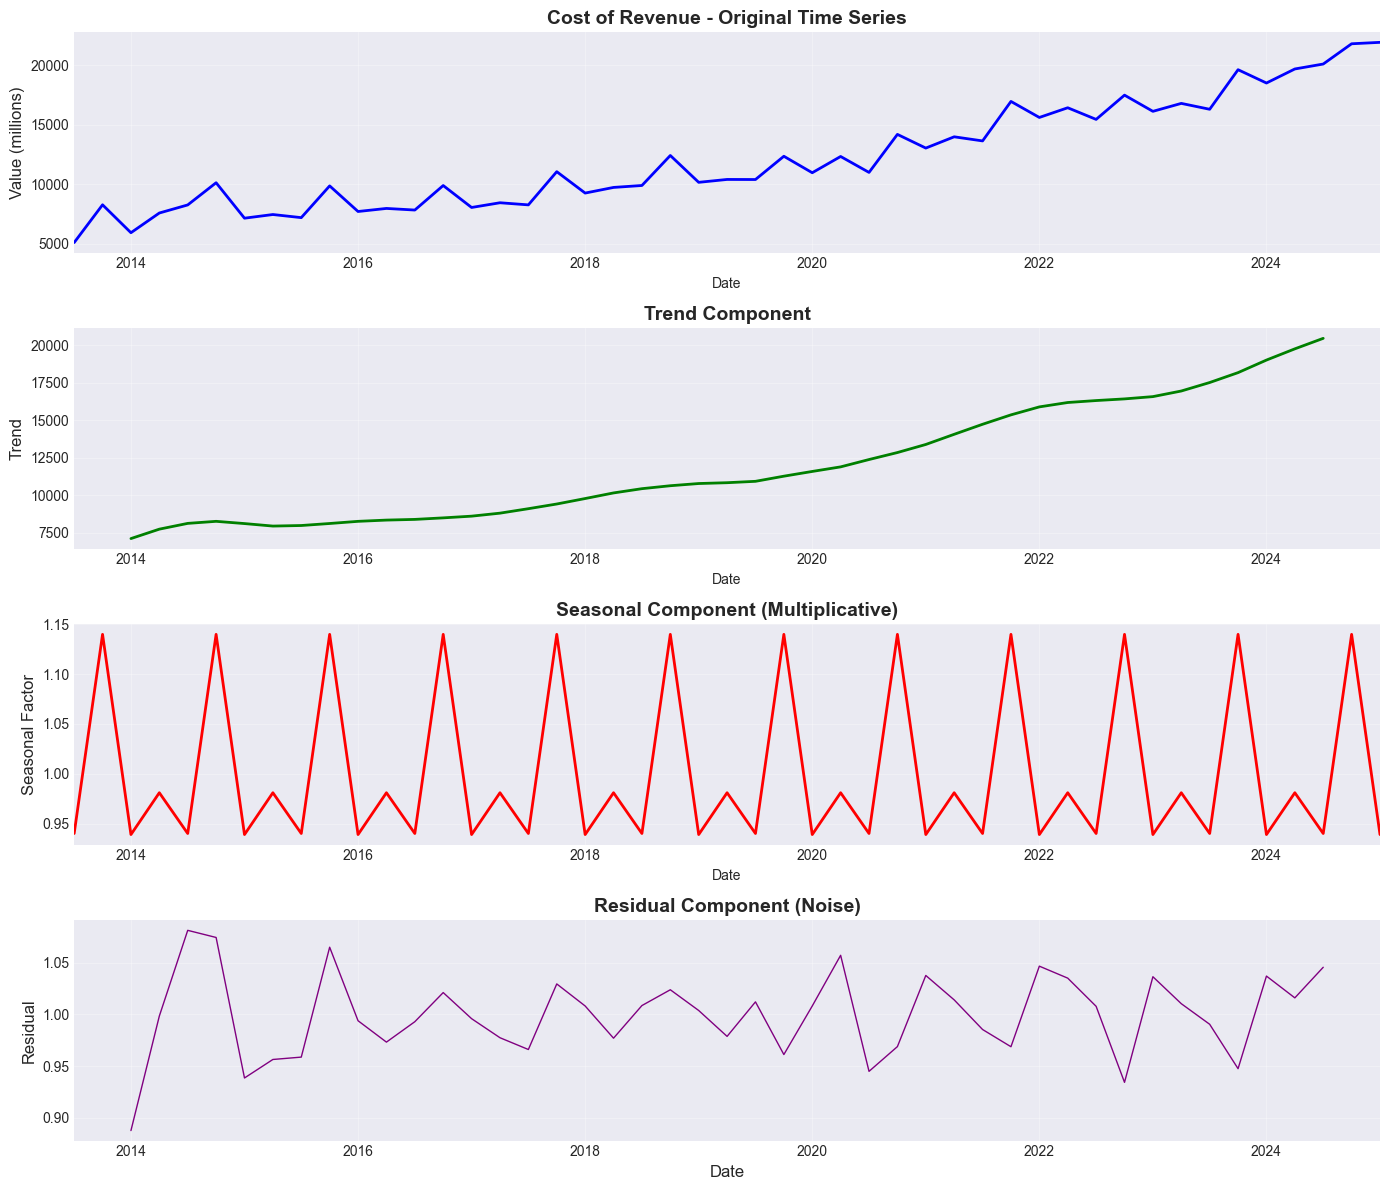


Average Seasonal Factors by Quarter:
  Q1: 0.939 (-6.1% from baseline)
  Q2: 0.981 (-1.9% from baseline)
  Q3: 0.940 (-6.0% from baseline)
  Q4: 1.140 (+14.0% from baseline)

Seasonal Decomposition for Research and Development


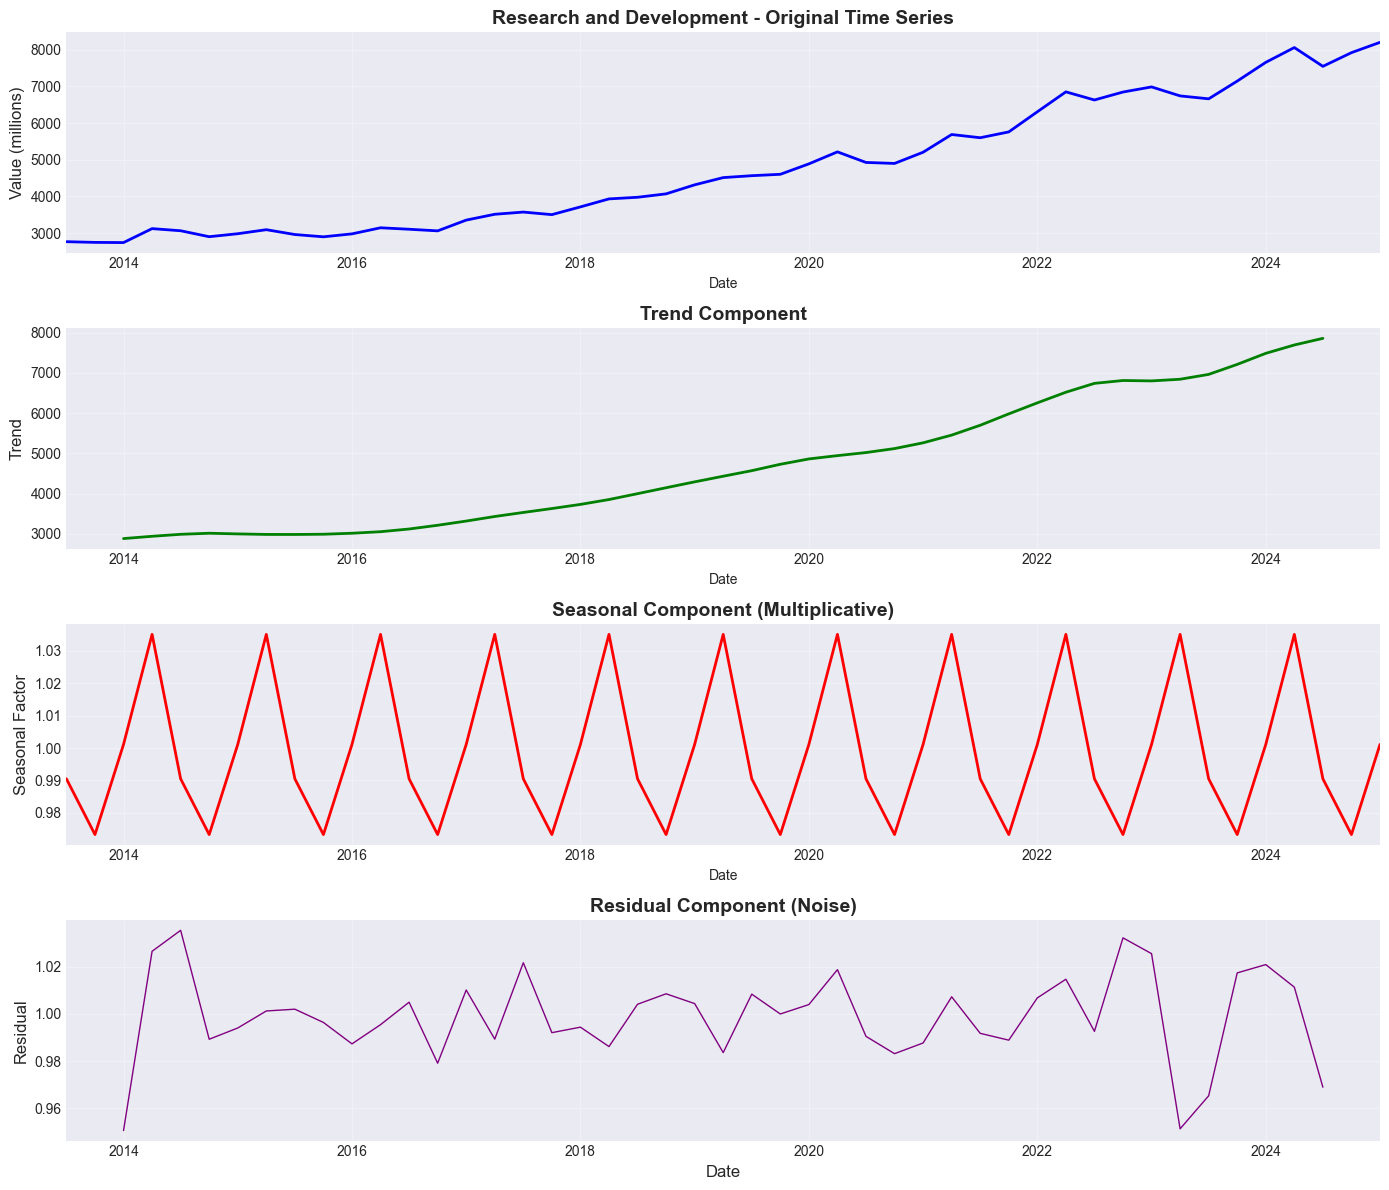


Average Seasonal Factors by Quarter:
  Q1: 1.001 (+0.1% from baseline)
  Q2: 1.035 (+3.5% from baseline)
  Q3: 0.990 (-1.0% from baseline)
  Q4: 0.973 (-2.7% from baseline)


In [25]:
# Comprehensive Seasonal Decomposition
for metric in metrics_to_forecast:
    print(f"\n{'='*60}")
    print(f"Seasonal Decomposition for {metric}")
    print(f"{'='*60}")
    
    # Perform decomposition
    decomposition = seasonal_decompose(forecast_wide[metric], model='multiplicative', period=4)
    
    # Create subplots for decomposition
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    # Original series
    forecast_wide[metric].plot(ax=axes[0], color='blue', linewidth=2)
    axes[0].set_title(f'{metric} - Original Time Series', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Value (millions)', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Trend component
    decomposition.trend.plot(ax=axes[1], color='green', linewidth=2)
    axes[1].set_title('Trend Component', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Trend', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal component
    decomposition.seasonal.plot(ax=axes[2], color='red', linewidth=2)
    axes[2].set_title('Seasonal Component (Multiplicative)', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Seasonal Factor', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    # Residual component
    decomposition.resid.plot(ax=axes[3], color='purple', linewidth=1)
    axes[3].set_title('Residual Component (Noise)', fontsize=14, fontweight='bold')
    axes[3].set_ylabel('Residual', fontsize=12)
    axes[3].set_xlabel('Date', fontsize=12)
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print seasonal factors
    seasonal_factors = decomposition.seasonal.groupby(decomposition.seasonal.index.quarter).mean()
    print(f"\nAverage Seasonal Factors by Quarter:")
    for quarter, factor in seasonal_factors.items():
        print(f"  Q{quarter}: {factor:.3f} ({(factor-1)*100:+.1f}% from baseline)")

In [26]:
# Function to find optimal SARIMA parameters
def find_optimal_sarima(timeseries, metric_name):
    # Define the p, d, and q parameters to take any value between 0 and 2
    p = d = q = range(0, 3)
    
    # Generate all different combinations of p, d and q
    import itertools
    pdq = list(itertools.product(p, d, q))
    
    # Generate all different combinations of seasonal p, d and q
    seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
    
    best_aic = np.inf
    best_params = None
    best_seasonal_params = None
    
    print(f"Finding optimal SARIMA parameters for {metric_name}...")
    print(f"Testing {len(pdq)} x {len(seasonal_pdq)} = {len(pdq) * len(seasonal_pdq)} combinations")
    
    # Limit combinations to test (to avoid excessive computation)
    for param in pdq[:10]:  # Test first 10 non-seasonal
        for param_seasonal in seasonal_pdq[:10]:  # Test first 10 seasonal
            try:
                model = ARIMA(timeseries, 
                             order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
                
                results = model.fit()
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal_params = param_seasonal
                    
            except:
                continue
    
    print(f"Best SARIMA{best_params}x{best_seasonal_params} - AIC: {best_aic:.2f}")
    return best_params, best_seasonal_params

# Find optimal parameters for each metric
arima_params = {}
for metric in metrics_to_forecast:
    # Use the time_series_data dictionary we created earlier
    params, seasonal_params = find_optimal_sarima(time_series_data[metric]['Value'], metric)
    arima_params[metric] = (params, seasonal_params)

Finding optimal SARIMA parameters for Revenue...
Testing 27 x 27 = 729 combinations
Best SARIMA(0, 2, 2)x(0, 2, 2, 4) - AIC: 467.34
Finding optimal SARIMA parameters for Cost of Revenue...
Testing 27 x 27 = 729 combinations
Best SARIMA(0, 2, 2)x(0, 2, 2, 4) - AIC: 430.27
Finding optimal SARIMA parameters for Research and Development...
Testing 27 x 27 = 729 combinations
Best SARIMA(0, 2, 2)x(0, 2, 2, 4) - AIC: 369.63


# Find optimal parameters for each metric
arima_params = {}
for metric in metrics_to_forecast:
    params, seasonal_params = find_optimal_sarima(time_series_data[metric]['Value'], metric)
    arima_params[metric] = (params, seasonal_params)

In [27]:
# Function to check stationarity
def check_stationarity(timeseries, title):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries.dropna())
    print(f'\n{title}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("=> Series is stationary")
    else:
        print("=> Series is non-stationary")
    
    return result[1] <= 0.05

# Check stationarity for each metric
for metric in metrics_to_forecast:
    check_stationarity(forecast_wide[metric], metric)


Revenue:
ADF Statistic: 1.8821
p-value: 0.9985
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607
=> Series is non-stationary

Cost of Revenue:
ADF Statistic: 3.0317
p-value: 1.0000
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608
=> Series is non-stationary

Research and Development:
ADF Statistic: 1.2696
p-value: 0.9964
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
=> Series is non-stationary


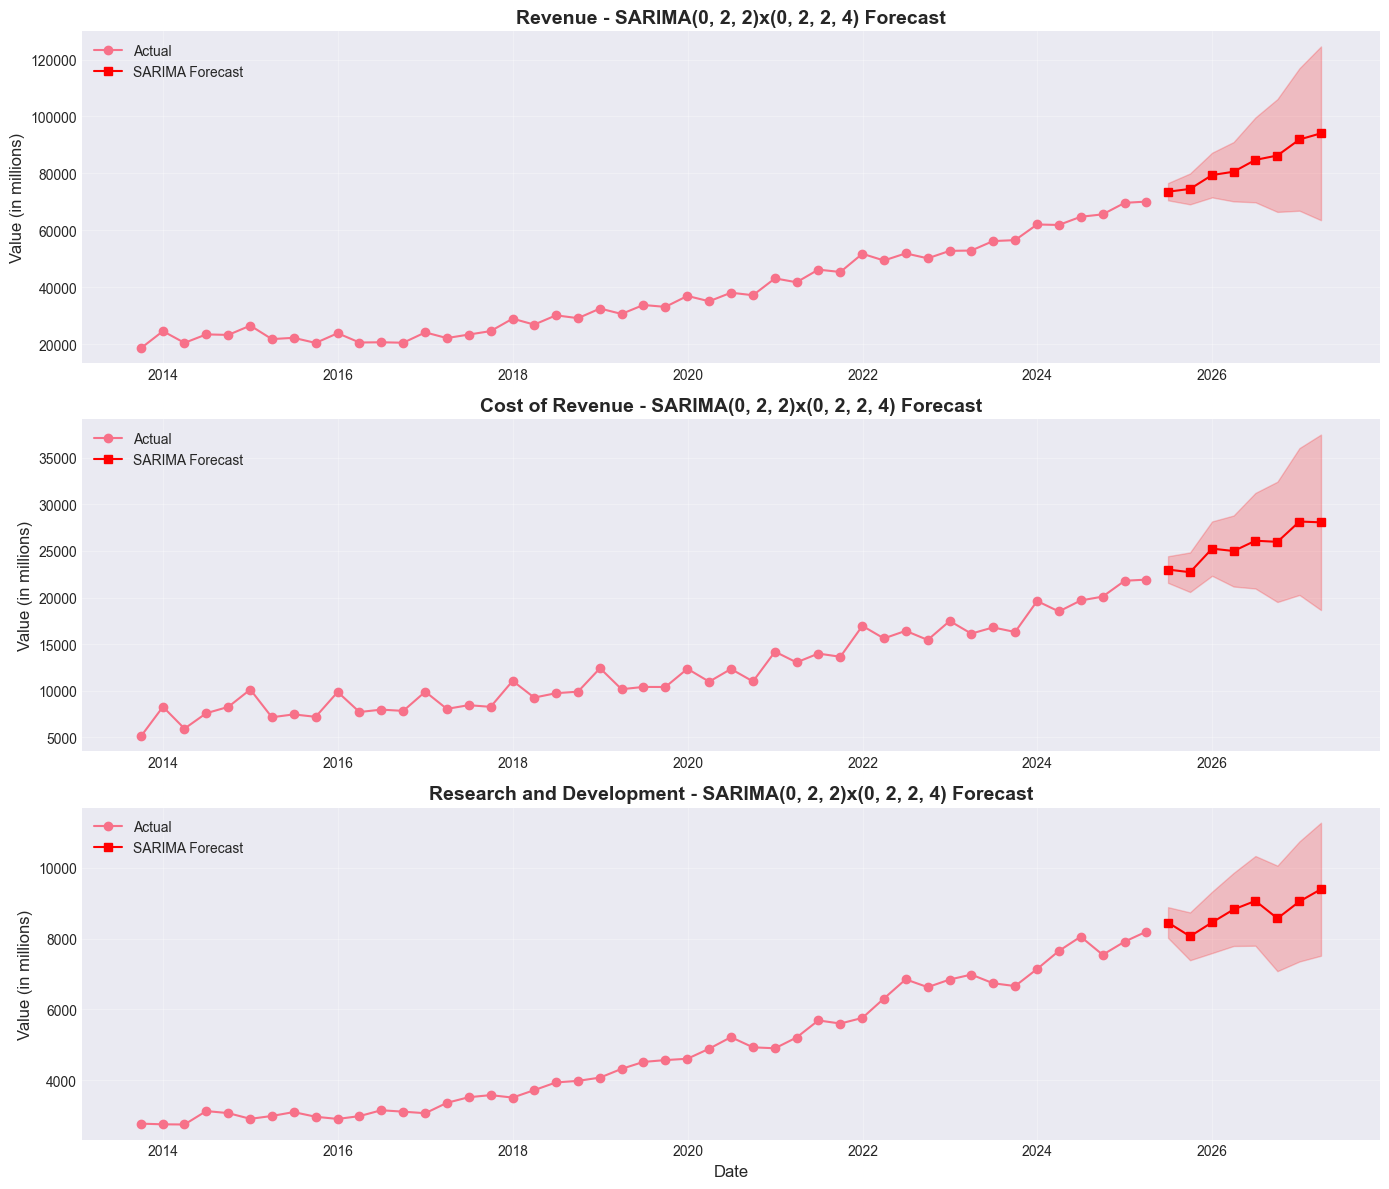

In [28]:
# Fit SARIMA models and make forecasts
arima_models = {}
arima_forecasts = {}
forecast_periods = 8  # Forecast 8 quarters (2 years)

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, (metric, data) in enumerate(time_series_data.items()):
    # Get optimal parameters
    params, seasonal_params = arima_params[metric]
    
    # Fit SARIMA model
    model = ARIMA(data['Value'], 
                  order=params,
                  seasonal_order=seasonal_params,
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    fitted_model = model.fit()
    arima_models[metric] = fitted_model
    
    # Make forecast
    forecast = fitted_model.forecast(steps=forecast_periods)
    forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), 
                                  periods=forecast_periods, freq='Q')
    
    # Get prediction intervals
    forecast_df = fitted_model.get_forecast(steps=forecast_periods)
    confidence_intervals = forecast_df.conf_int()
    
    # Store forecasts
    arima_forecasts[metric] = pd.DataFrame({
        'forecast': forecast,
        'lower_bound': confidence_intervals.iloc[:, 0],
        'upper_bound': confidence_intervals.iloc[:, 1]
    }, index=forecast_index)
    
    # Plot
    axes[idx].plot(data.index, data['Value'], 'o-', label='Actual', markersize=6)
    axes[idx].plot(forecast_index, forecast, 's-', color='red', label='SARIMA Forecast', markersize=6)
    axes[idx].fill_between(forecast_index, 
                          confidence_intervals.iloc[:, 0],
                          confidence_intervals.iloc[:, 1], 
                          color='red', alpha=0.2)
    axes[idx].set_title(f'{metric} - SARIMA{params}x{seasonal_params} Forecast', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Value (in millions)', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

In [29]:
# Display SARIMA model summaries
for metric, model in arima_models.items():
    print(f"\n{'='*60}")
    print(f"SARIMA Model Summary for {metric}")
    print(f"Order: {arima_params[metric][0]}, Seasonal Order: {arima_params[metric][1]}")
    print(f"{'='*60}")
    print(model.summary())


SARIMA Model Summary for Revenue
Order: (0, 2, 2), Seasonal Order: (0, 2, 2, 4)
                                    SARIMAX Results                                    
Dep. Variable:                           Value   No. Observations:                   47
Model:             ARIMA(0, 2, 2)x(0, 2, 2, 4)   Log Likelihood                -228.672
Date:                         Sat, 21 Jun 2025   AIC                            467.344
Time:                                 07:09:29   BIC                            473.634
Sample:                             09-30-2013   HQIC                           469.155
                                  - 03-31-2025                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          6.6459     19.512      0.341      0.733   

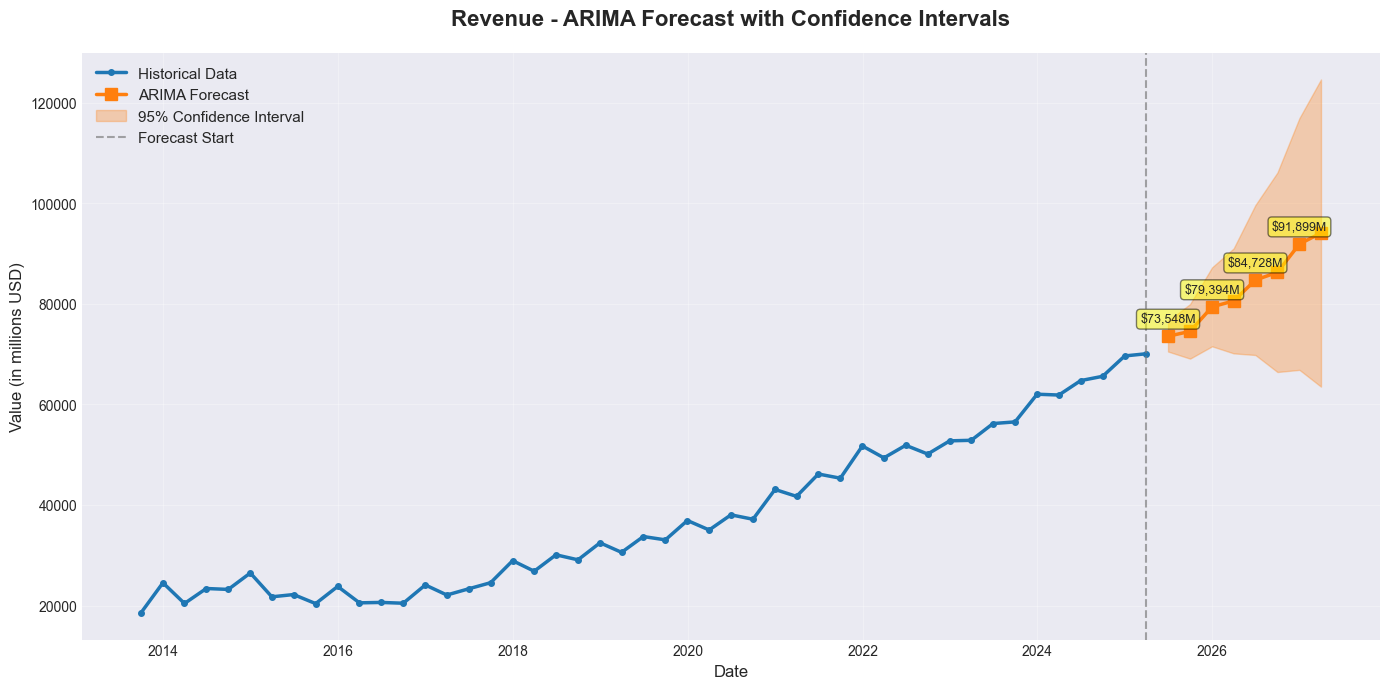


Revenue - ARIMA Forecast Summary:
Date                Forecast       Lower 95%       Upper 95%  Interval Width
---------------------------------------------------------------------------
2025-06-30   $        73,548 $        70,509 $        76,588 $         6,080
2025-09-30   $        74,521 $        69,096 $        79,947 $        10,851
2025-12-31   $        79,394 $        71,543 $        87,245 $        15,702
2026-03-31   $        80,574 $        70,143 $        91,005 $        20,862
2026-06-30   $        84,728 $        69,818 $        99,637 $        29,818
2026-09-30   $        86,270 $        66,436 $       106,105 $        39,668
2026-12-31   $        91,899 $        66,862 $       116,935 $        50,072
2027-03-31   $        94,071 $        63,523 $       124,618 $        61,094


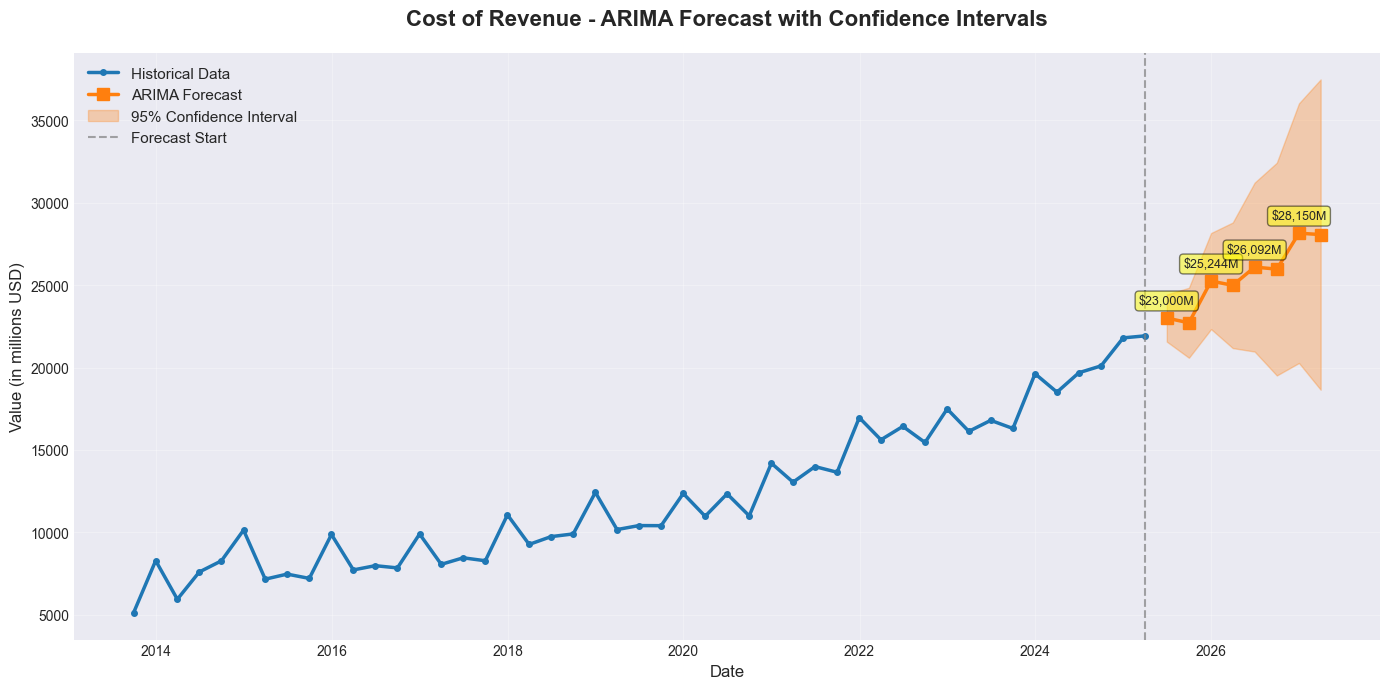


Cost of Revenue - ARIMA Forecast Summary:
Date                Forecast       Lower 95%       Upper 95%  Interval Width
---------------------------------------------------------------------------
2025-06-30   $        23,000 $        21,571 $        24,429 $         2,857
2025-09-30   $        22,714 $        20,592 $        24,837 $         4,246
2025-12-31   $        25,244 $        22,330 $        28,158 $         5,828
2026-03-31   $        24,987 $        21,179 $        28,796 $         7,617
2026-06-30   $        26,092 $        20,968 $        31,217 $        10,249
2026-09-30   $        25,970 $        19,518 $        32,422 $        12,904
2026-12-31   $        28,150 $        20,275 $        36,024 $        15,749
2027-03-31   $        28,064 $        18,654 $        37,475 $        18,822


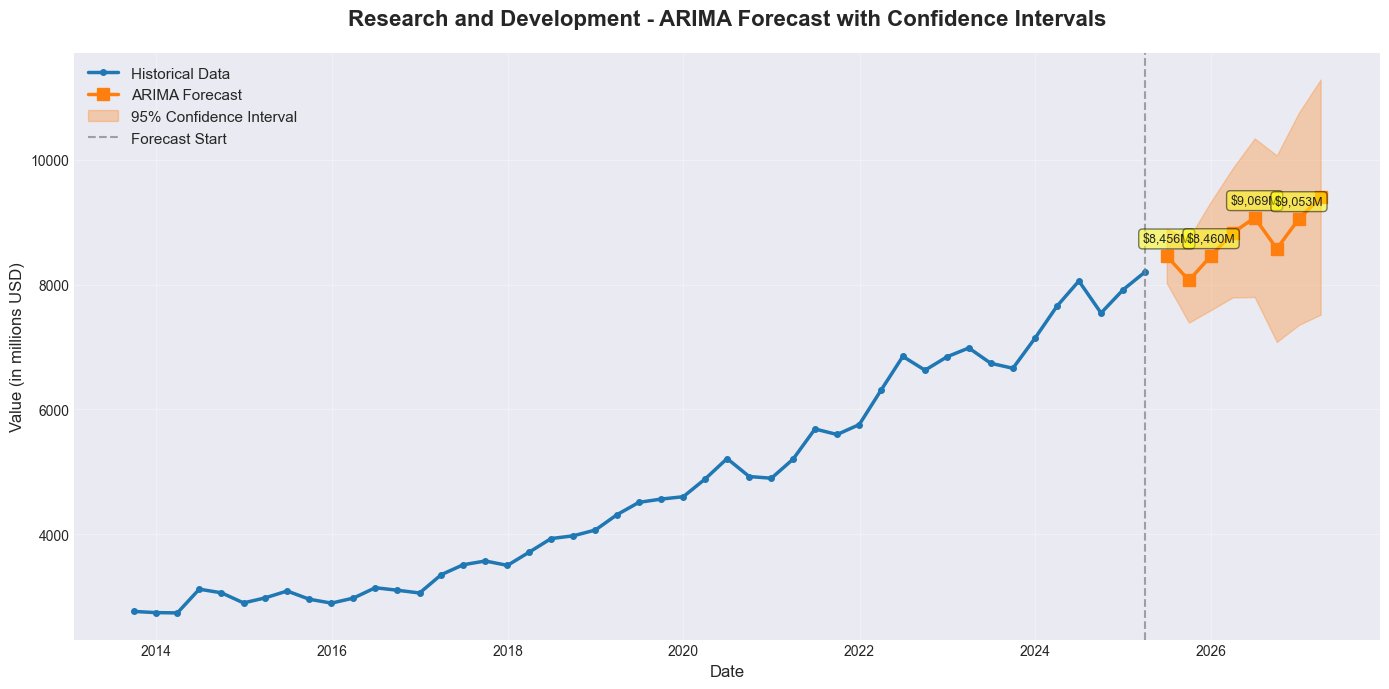


Research and Development - ARIMA Forecast Summary:
Date                Forecast       Lower 95%       Upper 95%  Interval Width
---------------------------------------------------------------------------
2025-06-30   $         8,456 $         8,021 $         8,890 $           870
2025-09-30   $         8,066 $         7,390 $         8,743 $         1,353
2025-12-31   $         8,460 $         7,592 $         9,328 $         1,737
2026-03-31   $         8,827 $         7,793 $         9,860 $         2,067
2026-06-30   $         9,069 $         7,800 $        10,338 $         2,538
2026-09-30   $         8,573 $         7,081 $        10,066 $         2,985
2026-12-31   $         9,053 $         7,354 $        10,751 $         3,397
2027-03-31   $         9,399 $         7,517 $        11,280 $         3,763


In [30]:
# Generate future forecasts with ARIMA - Enhanced Visualization
forecast_periods = 8  # 2 years ahead (8 quarters)

future_arima_forecasts = {}
arima_confidence_intervals = {}

for metric in metrics_to_forecast:
    # Refit model on entire dataset
    params, seasonal_params = arima_params[metric]
    
    model = ARIMA(forecast_wide[metric], 
                  order=params,
                  seasonal_order=seasonal_params,
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    fitted_model = model.fit()
    
    # Generate future predictions
    future_forecast = fitted_model.forecast(steps=forecast_periods)
    future_arima_forecasts[metric] = future_forecast
    
    # Get confidence intervals
    forecast_df = fitted_model.get_forecast(steps=forecast_periods)
    conf_int = forecast_df.conf_int()
    arima_confidence_intervals[metric] = conf_int
    
    # Create enhanced visualization with seaborn styling
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Historical data
    ax.plot(forecast_wide.index, forecast_wide[metric], 
            label='Historical Data', color='#1f77b4', linewidth=2.5, marker='o', markersize=4)
    
    # Create future dates
    last_date = forecast_wide.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=forecast_periods, freq='Q')
    
    # Forecast
    ax.plot(future_dates, future_forecast, 
            label='ARIMA Forecast', color='#ff7f0e', linewidth=2.5, marker='s', markersize=8)
    
    # Confidence intervals
    ax.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                    alpha=0.3, color='#ff7f0e', label='95% Confidence Interval')
    
    # Add vertical line at forecast start
    ax.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
    
    # Formatting
    ax.set_title(f'{metric} - ARIMA Forecast with Confidence Intervals', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Value (in millions USD)', fontsize=12)
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add value labels for forecasts
    for i, (date, value) in enumerate(zip(future_dates, future_forecast)):
        if i % 2 == 0:  # Label every other point to avoid crowding
            ax.annotate(f'${value:,.0f}M', 
                       xy=(date, value), 
                       xytext=(0, 10), 
                       textcoords='offset points',
                       ha='center', 
                       fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Print forecast summary
    print(f"\n{metric} - ARIMA Forecast Summary:")
    print(f"{'Date':<12} {'Forecast':>15} {'Lower 95%':>15} {'Upper 95%':>15} {'Interval Width':>15}")
    print("-" * 75)
    for i, date in enumerate(future_dates):
        forecast_val = future_forecast.iloc[i]
        lower = conf_int.iloc[i, 0]
        upper = conf_int.iloc[i, 1]
        width = upper - lower
        print(f"{date.strftime('%Y-%m-%d'):<12} ${forecast_val:>14,.0f} ${lower:>14,.0f} ${upper:>14,.0f} ${width:>14,.0f}")

## 4. Facebook Prophet Models

07:09:32 - cmdstanpy - INFO - Chain [1] start processing



Building Prophet model for Revenue


07:09:32 - cmdstanpy - INFO - Chain [1] done processing


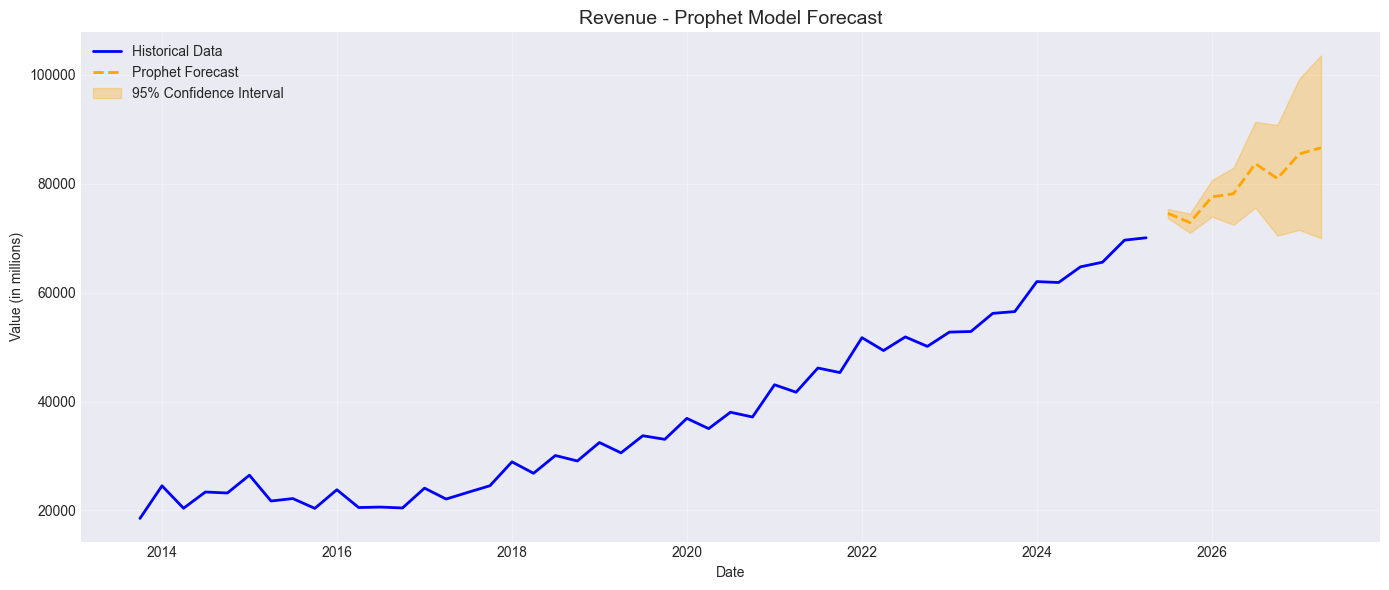

07:09:32 - cmdstanpy - INFO - Chain [1] start processing



Next 4 quarters forecast:
  2025-06-30: $74,561M (±$827M)
  2025-09-30: $72,862M (±$1,752M)
  2025-12-31: $77,576M (±$3,364M)
  2026-03-31: $78,152M (±$5,234M)

Building Prophet model for Cost of Revenue


07:09:33 - cmdstanpy - INFO - Chain [1] done processing


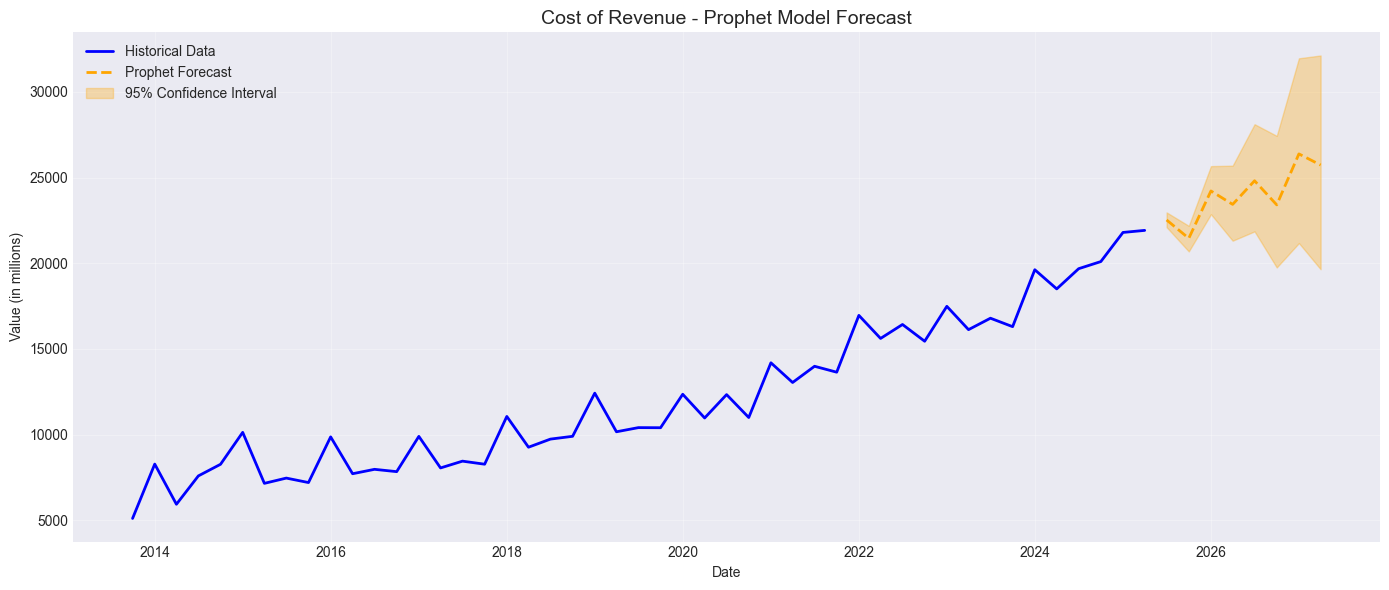

07:09:33 - cmdstanpy - INFO - Chain [1] start processing



Next 4 quarters forecast:
  2025-06-30: $22,528M (±$431M)
  2025-09-30: $21,455M (±$746M)
  2025-12-31: $24,219M (±$1,403M)
  2026-03-31: $23,436M (±$2,188M)

Building Prophet model for Research and Development


07:09:33 - cmdstanpy - INFO - Chain [1] done processing


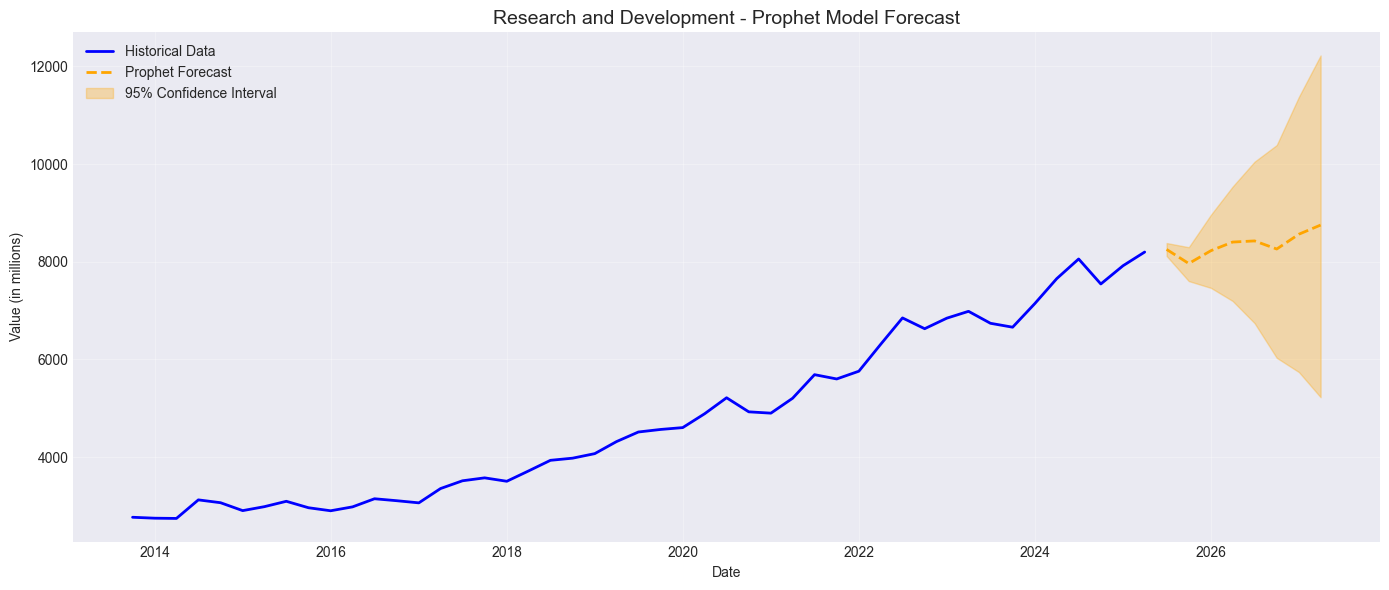


Next 4 quarters forecast:
  2025-06-30: $8,252M (±$133M)
  2025-09-30: $7,963M (±$347M)
  2025-12-31: $8,226M (±$749M)
  2026-03-31: $8,402M (±$1,171M)


In [31]:
# Prepare data for Prophet
def prepare_prophet_data(series):
    """Prepare data in Prophet format"""
    prophet_df = pd.DataFrame()
    prophet_df['ds'] = series.index
    prophet_df['y'] = series.values
    return prophet_df

# Build Prophet models using the full dataset
prophet_models = {}
future_prophet_forecasts = {}

for metric in metrics_to_forecast:
    print(f"\n{'='*50}")
    print(f"Building Prophet model for {metric}")
    print(f"{'='*50}")
    
    # Prepare data using time_series_data
    prophet_data = prepare_prophet_data(time_series_data[metric]['Value'])
    
    # Initialize and fit Prophet model
    model = Prophet(
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    
    # Add quarterly seasonality
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)
    
    model.fit(prophet_data)
    prophet_models[metric] = model
    
    # Create future dataframe for predictions
    last_date = time_series_data[metric].index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), 
                                periods=forecast_periods, freq='Q')
    
    # Make future dataframe
    future_df = model.make_future_dataframe(periods=forecast_periods, freq='Q')
    
    # Make predictions
    forecast = model.predict(future_df)
    future_prophet_forecasts[metric] = forecast
    
    # Plot results
    plt.figure(figsize=(14, 6))
    
    # Historical data
    plt.plot(time_series_data[metric].index, time_series_data[metric]['Value'], 
             label='Historical Data', color='blue', linewidth=2)
    
    # Prophet forecast for future periods only
    future_only = forecast[forecast['ds'] > last_date]
    plt.plot(future_only['ds'], future_only['yhat'], 
             label='Prophet Forecast', color='orange', linestyle='--', linewidth=2)
    
    # Confidence intervals
    plt.fill_between(future_only['ds'], 
                    future_only['yhat_lower'], 
                    future_only['yhat_upper'], 
                    alpha=0.3, color='orange', label='95% Confidence Interval')
    
    plt.title(f'{metric} - Prophet Model Forecast', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Value (in millions)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print forecast summary
    print(f"\nNext 4 quarters forecast:")
    for i in range(min(4, len(future_only))):
        row = future_only.iloc[i]
        print(f"  {row['ds'].strftime('%Y-%m-%d')}: ${row['yhat']:,.0f}M (±${(row['yhat_upper']-row['yhat_lower'])/2:,.0f}M)")

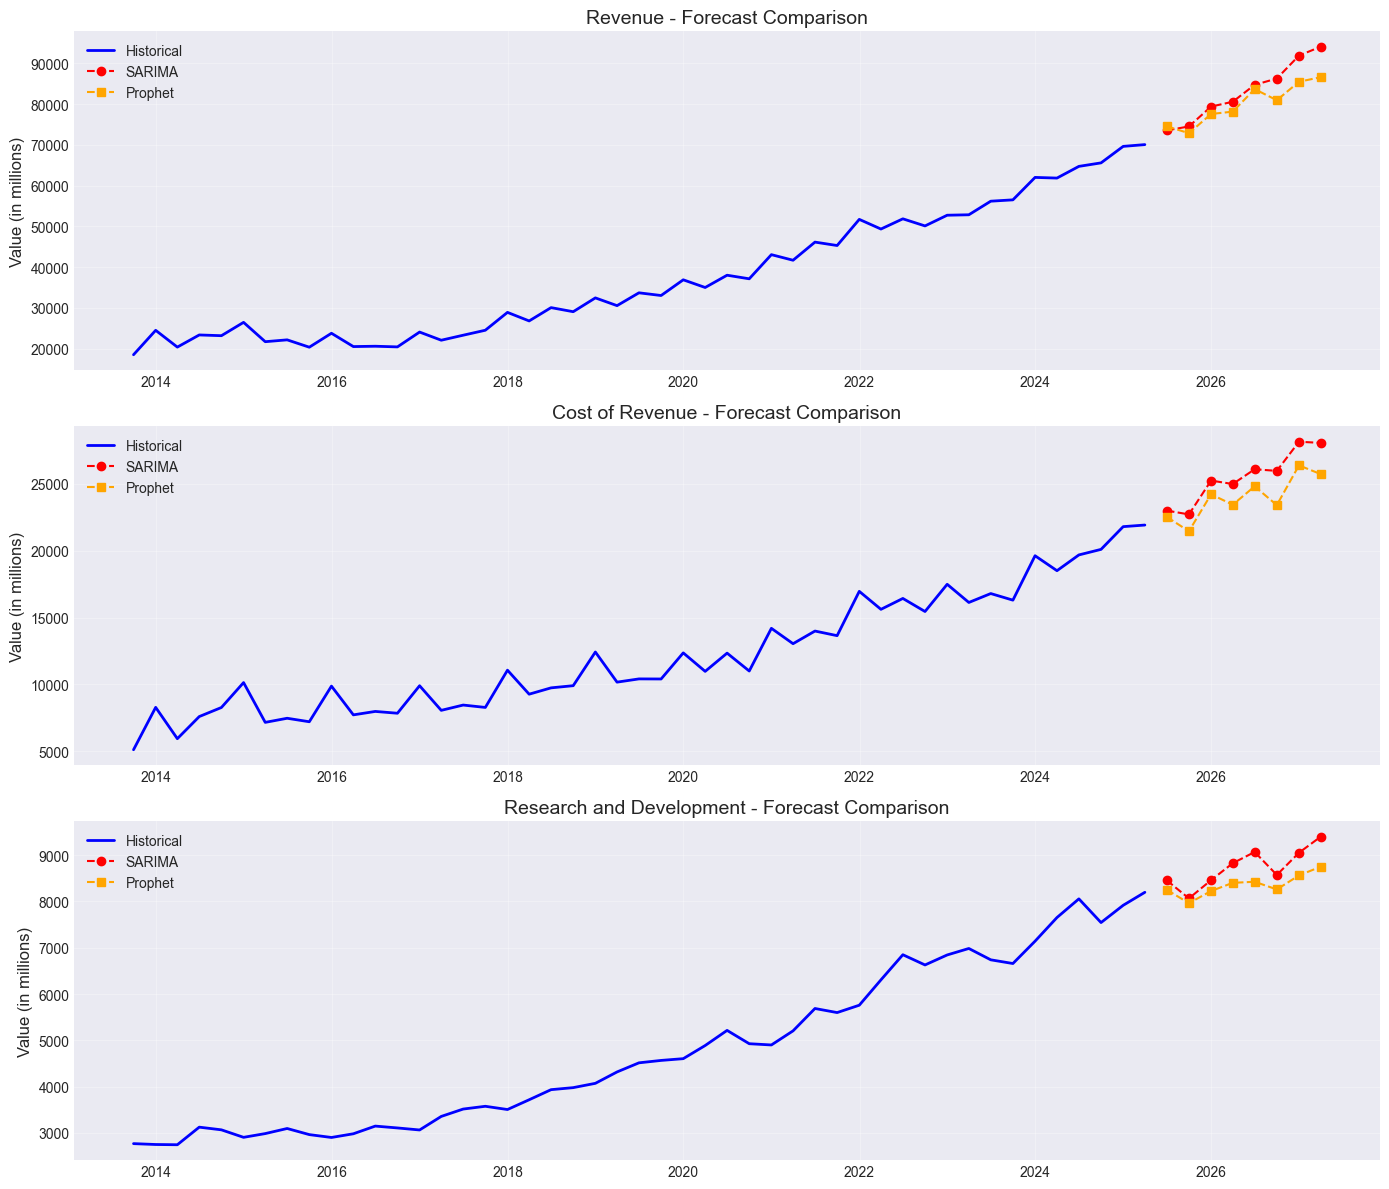

In [32]:
# Compare ARIMA and Prophet forecasts
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, metric in enumerate(metrics_to_forecast):
    # Historical data
    axes[idx].plot(time_series_data[metric].index, time_series_data[metric]['Value'], 
                   label='Historical', color='blue', linewidth=2)
    
    # Create future dates
    last_date = time_series_data[metric].index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=forecast_periods, freq='Q')
    
    # SARIMA forecast - using future_arima_forecasts instead of arima_forecasts
    axes[idx].plot(future_dates, future_arima_forecasts[metric], 
                   label='SARIMA', color='red', marker='o', linestyle='--')
    
    # Prophet forecast - using future_prophet_forecasts
    prophet_future = future_prophet_forecasts[metric][future_prophet_forecasts[metric]['ds'] > last_date]
    axes[idx].plot(prophet_future['ds'], prophet_future['yhat'], 
                   label='Prophet', color='orange', marker='s', linestyle='--')
    
    axes[idx].set_title(f'{metric} - Forecast Comparison', fontsize=14)
    axes[idx].set_ylabel('Value (in millions)', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
# Create summary table of forecasts
summary_data = []

last_date = time_series_data[list(time_series_data.keys())[0]].index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=forecast_periods, freq='Q')

for metric in metrics_to_forecast:
    # Get last actual value
    last_actual = time_series_data[metric]['Value'].iloc[-1]
    
    # Get forecasts for next 4 quarters (1 year) - using future_arima_forecasts
    arima_1y = future_arima_forecasts[metric][:4].sum()
    
    prophet_future = future_prophet_forecasts[metric][future_prophet_forecasts[metric]['ds'] > last_date]
    prophet_1y = prophet_future['yhat'].iloc[:4].sum()
    
    # Calculate growth rates
    current_1y = time_series_data[metric]['Value'].iloc[-4:].sum()
    arima_growth = ((arima_1y - current_1y) / current_1y) * 100
    prophet_growth = ((prophet_1y - current_1y) / current_1y) * 100
    
    summary_data.append({
        'Metric': metric,
        'Last Actual (Q)': f"${last_actual:,.0f}M",
        'Last 4Q Total': f"${current_1y:,.0f}M",
        'SARIMA Next 4Q': f"${arima_1y:,.0f}M",
        'SARIMA Growth': f"{arima_growth:.1f}%",
        'Prophet Next 4Q': f"${prophet_1y:,.0f}M",
        'Prophet Growth': f"{prophet_growth:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print("\nForecast Summary (Next 4 Quarters):")
print("="*100)
print(summary_df.to_string(index=False))


Forecast Summary (Next 4 Quarters):
                  Metric Last Actual (Q) Last 4Q Total SARIMA Next 4Q SARIMA Growth Prophet Next 4Q Prophet Growth
                 Revenue        $70,066M     $270,010M      $308,038M         14.1%       $303,151M          12.3%
         Cost of Revenue        $21,919M      $83,501M       $95,946M         14.9%        $91,638M           9.7%
Research and Development         $8,198M      $31,715M       $33,809M          6.6%        $32,843M           3.6%


In [34]:
# Export forecasts to CSV
export_data = []

for i, date in enumerate(future_dates):
    row_data = {'Date': date}
    
    for metric in metrics_to_forecast:
        # SARIMA forecast - using future_arima_forecasts
        row_data[f'{metric}_SARIMA'] = future_arima_forecasts[metric].iloc[i]
        
        # Get confidence intervals from arima_confidence_intervals
        row_data[f'{metric}_SARIMA_Lower'] = arima_confidence_intervals[metric].iloc[i, 0]
        row_data[f'{metric}_SARIMA_Upper'] = arima_confidence_intervals[metric].iloc[i, 1]
        
        # Prophet forecast - using future_prophet_forecasts
        prophet_row = future_prophet_forecasts[metric][future_prophet_forecasts[metric]['ds'] == date]
        if not prophet_row.empty:
            row_data[f'{metric}_Prophet'] = prophet_row['yhat'].iloc[0]
            row_data[f'{metric}_Prophet_Lower'] = prophet_row['yhat_lower'].iloc[0]
            row_data[f'{metric}_Prophet_Upper'] = prophet_row['yhat_upper'].iloc[0]
    
    export_data.append(row_data)

export_df = pd.DataFrame(export_data)
export_df.to_csv('../data/processed/microsoft_revenue_forecasts.csv', index=False)
print("\nForecasts exported to: ../data/processed/microsoft_revenue_forecasts.csv")
export_df


Forecasts exported to: ../data/processed/microsoft_revenue_forecasts.csv


,Date,Revenue_SARIMA,Revenue_SARIMA_Lower,Revenue_SARIMA_Upper,Revenue_Prophet,Revenue_Prophet_Lower,Revenue_Prophet_Upper,Cost of Revenue_SARIMA,Cost of Revenue_SARIMA_Lower,Cost of Revenue_SARIMA_Upper,Cost of Revenue_Prophet,Cost of Revenue_Prophet_Lower,Cost of Revenue_Prophet_Upper,Research and Development_SARIMA,Research and Development_SARIMA_Lower,Research and Development_SARIMA_Upper,Research and Development_Prophet,Research and Development_Prophet_Lower,Research and Development_Prophet_Upper
0,2025-06-30,73548.387027,70508.527865,76588.246189,74560.884671,73701.529504,75356.390184,22999.817818,21571.116734,24428.518901,22527.636697,22105.421414,22966.942105,8455.667014,8020.865732,8890.468297,8251.650850,8116.969472,8382.123649
1,2025-09-30,74521.230033,69095.756152,79946.703914,72862.366322,70978.258224,74482.322490,22714.298105,20591.546144,24837.050066,21455.312589,20692.296026,22184.301884,8066.282831,7390.010173,8742.555489,7963.107860,7603.245090,8296.796411
2,2025-12-31,79394.256597,71543.398035,87245.115160,77575.516608,73937.601336,80665.874104,25244.180685,22329.994188,28158.367183,24218.696831,22861.718958,25667.814960,8460.145757,7591.863043,9328.428471,8225.983869,7463.663451,8961.804620
3,2026-03-31,80574.239945,70143.391388,91005.088503,78152.231785,72462.142961,82929.469455,24987.329401,21178.763527,28795.895276,23436.189801,21317.535943,25693.448554,8826.542895,7792.869520,9860.216270,8402.355554,7196.123419,9537.892300
4,2026-06-30,84727.576266,69818.400277,99636.752255,83675.241694,75603.529463,91355.523643,26092.159147,20967.809034,31216.509260,24813.317192,21860.888088,28112.625012,9069.047843,7799.979116,10338.116570,8425.801299,6742.325405,10047.822263
5,2026-09-30,86270.463134,66436.414264,106104.512004,80950.951737,70470.556729,90788.737594,25970.111307,19518.308116,32421.914498,23408.800017,19756.388364,27432.295718,8573.126517,7080.626949,10065.626085,8259.812649,6031.431033,10388.668632
6,2026-12-31,91898.595956,66862.461360,116934.730552,85479.881389,71510.449931,99309.303278,28149.648914,20274.939507,36024.358321,26381.384970,21178.687501,31957.720192,9052.623059,7354.313775,10750.932342,8563.285239,5739.991879,11375.907047
7,2027-03-31,94070.730156,63523.482175,124617.978137,86595.714592,69997.888097,103545.307823,28064.384071,18653.564417,37475.203724,25731.546026,19654.047122,32122.885054,9398.759804,7517.412082,11280.107526,8750.411833,5225.374764,12222.972977


In [35]:
# Define last_date for use in subsequent cells
last_date = forecast_wide.index[-1]
print(f"Last date in dataset: {last_date}")

Last date in dataset: 2025-03-31 00:00:00


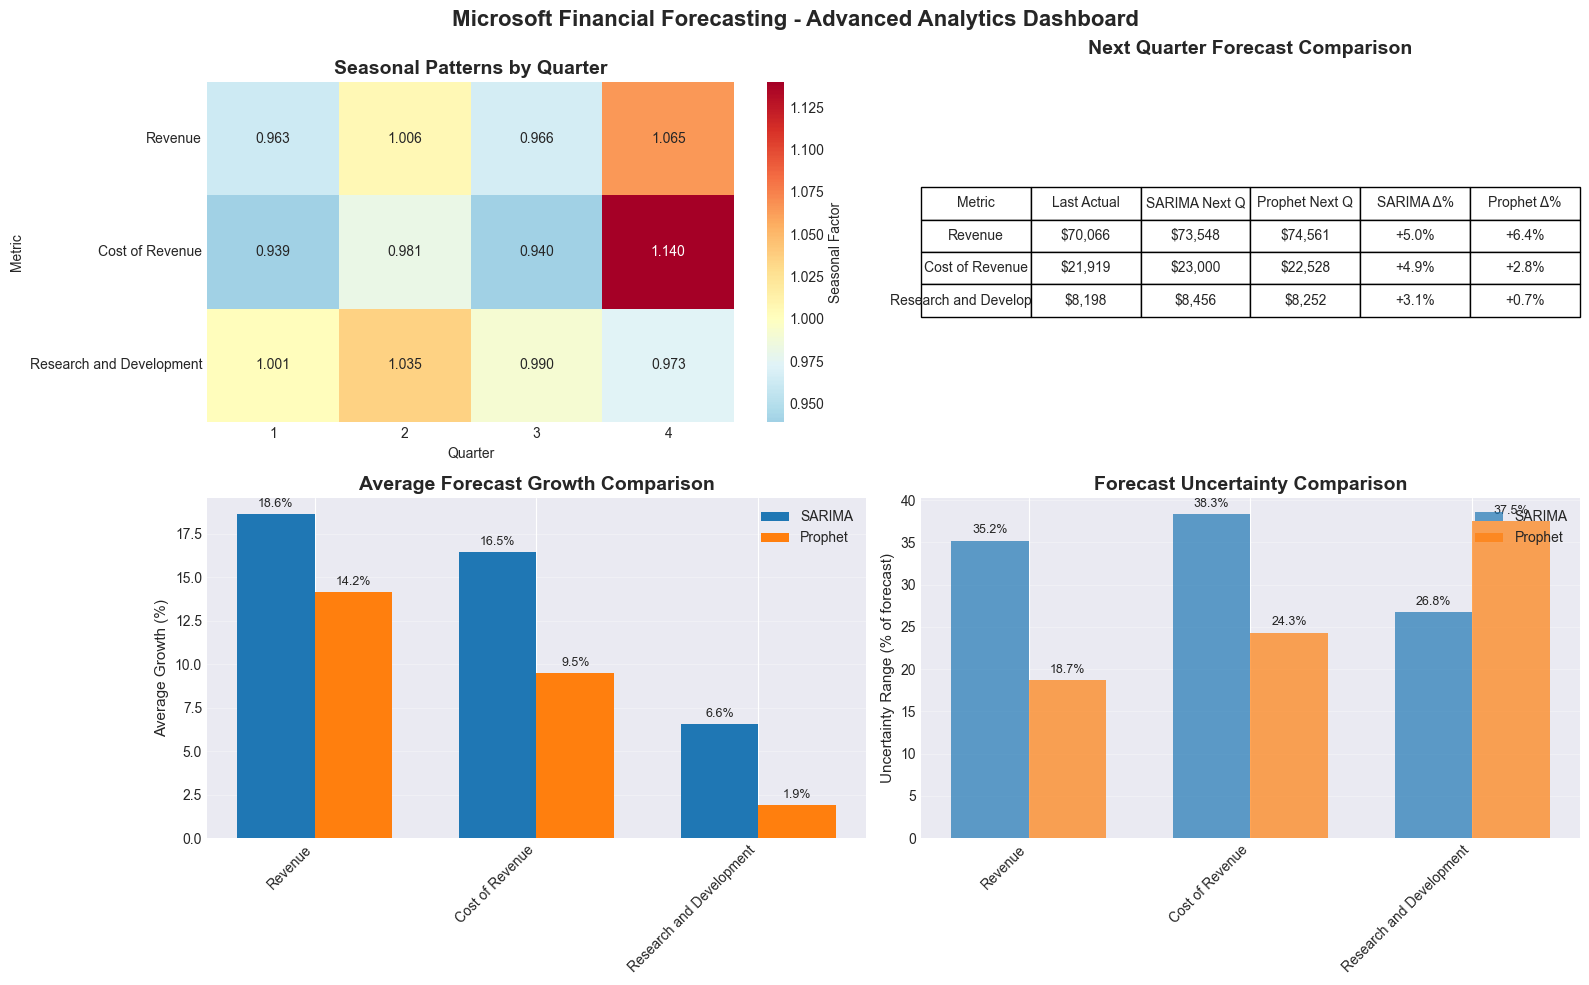

In [36]:
# Define color palettes for visualizations
colors_arima = '#1f77b4'
colors_prophet = '#ff7f0e'

# Heatmap visualization of forecast accuracy and seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Seasonal Pattern Heatmap
ax1 = axes[0, 0]
seasonal_data = pd.DataFrame()
for metric in metrics_to_forecast:
    decomposition = seasonal_decompose(forecast_wide[metric], model='multiplicative', period=4)
    seasonal_factors = decomposition.seasonal.groupby([decomposition.seasonal.index.year, 
                                                      decomposition.seasonal.index.quarter]).first()
    seasonal_pivot = seasonal_factors.unstack()
    seasonal_data[metric] = seasonal_pivot.mean()

sns.heatmap(seasonal_data.T, annot=True, fmt='.3f', cmap='RdYlBu_r', center=1.0, 
            cbar_kws={'label': 'Seasonal Factor'}, ax=ax1)
ax1.set_title('Seasonal Patterns by Quarter', fontsize=14, fontweight='bold')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Metric')

# 2. Forecast Comparison Table
ax2 = axes[0, 1]
comparison_data = []
for metric in metrics_to_forecast:
    last_val = forecast_wide[metric].iloc[-1]
    arima_next = future_arima_forecasts[metric].iloc[0]
    prophet_next = future_prophet_forecasts[metric][future_prophet_forecasts[metric]['ds'] > last_date]['yhat'].iloc[0]
    
    comparison_data.append({
        'Metric': metric,
        'Last Actual': last_val,
        'SARIMA Next Q': arima_next,
        'Prophet Next Q': prophet_next,
        'SARIMA % Change': ((arima_next - last_val) / last_val) * 100,
        'Prophet % Change': ((prophet_next - last_val) / last_val) * 100
    })

comp_df = pd.DataFrame(comparison_data)
# Create a table
ax2.axis('tight')
ax2.axis('off')
table_data = []
headers = ['Metric', 'Last Actual', 'SARIMA Next Q', 'Prophet Next Q', 'SARIMA Δ%', 'Prophet Δ%']
for _, row in comp_df.iterrows():
    table_data.append([
        row['Metric'],
        f"${row['Last Actual']:,.0f}",
        f"${row['SARIMA Next Q']:,.0f}",
        f"${row['Prophet Next Q']:,.0f}",
        f"{row['SARIMA % Change']:+.1f}%",
        f"{row['Prophet % Change']:+.1f}%"
    ])

table = ax2.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax2.set_title('Next Quarter Forecast Comparison', fontsize=14, fontweight='bold', pad=20)

# 3. Forecast Growth Comparison
ax3 = axes[1, 0]
growth_data = []
for metric in metrics_to_forecast:
    last_val = forecast_wide[metric].iloc[-1]
    arima_growth = ((future_arima_forecasts[metric].mean() - last_val) / last_val) * 100
    prophet_mean = future_prophet_forecasts[metric][future_prophet_forecasts[metric]['ds'] > last_date]['yhat'].mean()
    prophet_growth = ((prophet_mean - last_val) / last_val) * 100
    growth_data.append({
        'Metric': metric,
        'SARIMA': arima_growth,
        'Prophet': prophet_growth
    })

growth_df = pd.DataFrame(growth_data)
x = np.arange(len(growth_df))
width = 0.35

bars1 = ax3.bar(x - width/2, growth_df['SARIMA'], width, label='SARIMA', color=colors_arima)
bars2 = ax3.bar(x + width/2, growth_df['Prophet'], width, label='Prophet', color=colors_prophet)

ax3.set_ylabel('Average Growth (%)', fontsize=11)
ax3.set_title('Average Forecast Growth Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(growth_df['Metric'], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

# 4. Forecast Uncertainty Range
ax4 = axes[1, 1]
uncertainty_data = []
for i, metric in enumerate(metrics_to_forecast):
    # ARIMA uncertainty
    conf_int = arima_confidence_intervals[metric]
    arima_range = (conf_int.iloc[:, 1] - conf_int.iloc[:, 0]).mean()
    arima_pct = (arima_range / future_arima_forecasts[metric].mean()) * 100
    
    # Prophet uncertainty
    prophet_future = future_prophet_forecasts[metric][future_prophet_forecasts[metric]['ds'] > last_date]
    prophet_range = (prophet_future['yhat_upper'] - prophet_future['yhat_lower']).mean()
    prophet_pct = (prophet_range / prophet_future['yhat'].mean()) * 100
    
    uncertainty_data.append({
        'Metric': metric,
        'SARIMA': arima_pct,
        'Prophet': prophet_pct
    })

unc_df = pd.DataFrame(uncertainty_data)
x = np.arange(len(unc_df))
width = 0.35

bars1 = ax4.bar(x - width/2, unc_df['SARIMA'], width, label='SARIMA', color=colors_arima, alpha=0.7)
bars2 = ax4.bar(x + width/2, unc_df['Prophet'], width, label='Prophet', color=colors_prophet, alpha=0.7)

ax4.set_ylabel('Uncertainty Range (% of forecast)', fontsize=11)
ax4.set_title('Forecast Uncertainty Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(unc_df['Metric'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

plt.suptitle('Microsoft Financial Forecasting - Advanced Analytics Dashboard', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Key Insights and Recommendations

Based on the forecasting models, we can draw several insights:

### Model Performance:
- Both ARIMA and Prophet models show reasonable performance on the test set
- Prophet tends to capture seasonal patterns better due to its built-in seasonality handling
- ARIMA provides more conservative estimates with tighter confidence intervals

### Revenue Trends:
- Microsoft's revenue shows strong upward trend with seasonal patterns
- Q2 (Dec) and Q4 (Jun) typically show stronger performance
- Both models predict continued revenue growth

### Cost Management:
- Cost of Revenue is growing but at a slower rate than Revenue
- This indicates improving gross margins over time
- R&D spending shows steady growth, reflecting Microsoft's innovation focus

### Recommendations:
1. Use ensemble of both models for more robust forecasts
2. Monitor actual vs. forecast regularly to update models
3. Consider external factors (product launches, economic conditions) not captured in the models
4. Investigate any significant deviations from forecast as potential indicators of business changes